This notebook loads the 4 run-to-failure MOSFET tests #09, #11, #12 and #36 of NASA's MOSFET dataset that contain the preprocessed values of the Delta-RDSon [1].

After loading the run-to-failure datasets, the Temporal Fusion Transformer will be trained using the 100% of the samples of 2 complete run-to-failure tests. Finally, the performance will be tested on an unseen run-to-failure test evaluated at different forecasting horizons.

Note: The presented results were obtained with the version 0.24.0 of Darts. The use of a different Darts version may affect the results.

[1] J. Celaya et al. "MOSFET Thermal Overstress Aging Data Set". In: NASA AMES Prognostics Data Repository (2007). URL: https://www.nasa.gov/intelligent-systems-division/discovery-and-systemshealth/pcoe/pcoe-data-set-repository/.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.explainability import TFTExplainer
import warnings
import time
from scipy.optimize import curve_fit

from pathlib import Path

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Read data

In [3]:
# before starting, we define some constants
num_samples = 500  #samples per forecast
# default quantiles for QuantileRegression
quantiles = [0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99,]
#Figure Size
figsize = (9, 6)
#Percentiles for plotting
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
#Path to directory containing the csvs
DATAPATH = Path("./RDSon_CSVs/")
test11_df = pd.read_csv(DATAPATH / "Test_11_RDSon.csv", names=['rdson'])
test12_df = pd.read_csv(DATAPATH / "Test_12_RDSon.csv", names=['rdson'])
test09_df = pd.read_csv(DATAPATH / "Test_09_RDSon.csv", names=['rdson'])
test36_df = pd.read_csv(DATAPATH / "Test_36_RDSon.csv", names=['rdson'])
print("Test 11 shape: ", test11_df.shape)
print("Test 09 shape: ", test09_df.shape)
print("Test 36 shape: ", test36_df.shape)
#convert Test DFs into TimeSeries
test11_series = TimeSeries.from_dataframe(test11_df)
#test11_series = test11_series[0:93]
test09_series = TimeSeries.from_dataframe(test09_df)
#test09_series = test09_series[0:90]
test36_series = TimeSeries.from_dataframe(test36_df)
test12_series = TimeSeries.from_dataframe(test12_df)
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer_11, transformer_09, transformer_36 = Scaler(), Scaler(), Scaler()
test_11_transformed = transformer_11.fit_transform(test11_series)
test_11_transformed_trimmed = test_11_transformed[0:93]
test_09_transformed = transformer_09.fit_transform(test09_series)
test_09_transformed_trimmed = test_09_transformed[0:90]
test_36_transformed = transformer_36.fit_transform(test36_series)

Test 11 shape:  (100, 1)
Test 09 shape:  (100, 1)
Test 36 shape:  (100, 1)


# Aux functions

In [4]:
def func(t, a, b):
    #Function used to fit portions of the Test's curves to a straight line
    return a * t + b

In [5]:
def split_n_fitlines(test_series):
    #This function splits the series in blocks of 20 samples, then for each block it fits a straight line through Least Squares.
    y1 = test_series.slice(0, 20)
    y2 = test_series.slice(20, 40)
    y3 = test_series.slice(40, 60)
    y4 = test_series.slice(60, 80)
    y5 = test_series.slice(80, 100)
    #Create time vectors
    timeVector1 = np.arange(0, 20).astype(float)
    timeVector2 = np.arange(20, 40).astype(float)
    timeVector3 = np.arange(40, 60).astype(float)
    timeVector4 = np.arange(60, 80).astype(float)
    timeVector5 = np.arange(80, 100).astype(float)
    #Convert from df to np
    y1 = y1.pd_dataframe().to_numpy(copy=True, dtype=float)
    y2 = y2.pd_dataframe().to_numpy(copy=True, dtype=float)
    y3 = y3.pd_dataframe().to_numpy(copy=True, dtype=float)
    y4 = y4.pd_dataframe().to_numpy(copy=True, dtype=float)
    y5 = y5.pd_dataframe().to_numpy(copy=True, dtype=float)
    #Fit the curve specified in "func"
    popt1, _ = curve_fit(func, timeVector1.flatten('F'), y1.flatten('F'),
                         p0=(1, y1.flatten()[1]))
    popt2, _ = curve_fit(func, timeVector1.flatten('F'), y2.flatten('F'),
                         p0=(1, y2.flatten()[1]))
    popt3, _ = curve_fit(func, timeVector1.flatten('F'), y3.flatten('F'),
                         p0=(1, y3.flatten()[1]))
    popt4, _ = curve_fit(func, timeVector1.flatten('F'), y4.flatten('F'),
                         p0=(1, y4.flatten()[1]))
    popt5, _ = curve_fit(func, timeVector1.flatten('F'), y5.flatten('F'),
                         p0=(1, y5.flatten()[1]))
    #Obtain the y vals of the time vectors using the coefficients obtained from fitting
    vals1 = popt1[0] * timeVector1 + popt1[1]
    vals2 = popt2[0] * timeVector2 + popt2[1]
    vals3 = popt3[0] * timeVector3 + popt3[1]
    vals4 = popt4[0] * timeVector4 + popt4[1]
    vals5 = popt5[0] * timeVector5 + popt5[1]
    #Create TimeSeries objects for each batch
    cov_vector1 = TimeSeries.from_values(vals1, columns=["fitted_curve"])
    cov_vector2 = TimeSeries.from_values(vals2, columns=["fitted_curve"])
    cov_vector3 = TimeSeries.from_values(vals3, columns=["fitted_curve"])
    cov_vector4 = TimeSeries.from_values(vals4, columns=["fitted_curve"])
    cov_vector5 = TimeSeries.from_values(vals5, columns=["fitted_curve"])
    #Concatenate batches
    cov_vector = cov_vector1.concatenate(cov_vector2, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector3, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector4, ignore_time_axis=True)
    cov_vector = cov_vector.concatenate(cov_vector5, ignore_time_axis=True)
    #Normalize between 0 and 1
    comps_transformer = Scaler()
    cov_transf = comps_transformer.fit_transform(cov_vector)
    #Return the TimeSeries normalized piece-wise linearization
    return cov_transf

# Covariate design

## Piecewise covariate with a fitted line every 20 samples

In [6]:
t36_lines = split_n_fitlines(test36_series)
t36_lines = t36_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test36"])
#t36_lines.plot()
t11_lines = split_n_fitlines(test11_series)
t11_lines = t11_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test11"])
#t11_lines.plot()
t09_lines = split_n_fitlines(test09_series)
t09_lines = t09_lines.with_columns_renamed(col_names=["fitted_curve"],
                                           col_names_new=["Test09"])
#t09_lines.plot()

<Axes: xlabel='time'>

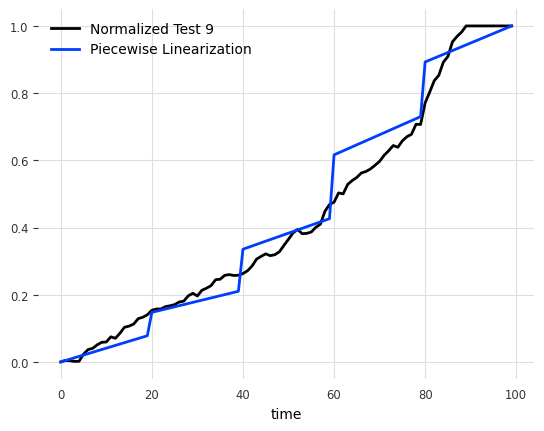

In [7]:
#Example of the piecewise linearization used to create the covariates
test_09_transformed.plot(label="Normalized Test 9")
t09_lines.plot(label="Piecewise Linearization")

## Time index covariate

In [8]:
# create integer index covariate series
example_RI = pd.RangeIndex(start=0, stop=100, step=1)
covariates = TimeSeries.from_times_and_values(
    times=example_RI,
    values=np.arange(len(example_RI)),
    columns=["linear_increase"],
).astype(np.float32)
#Normalize the time idx
scaler_covs = Scaler()
covariates_transformed = scaler_covs.fit_transform(covariates)

# Test selection for training and testing

In [9]:
#Select training and evaluation tests according to selector
SELECTOR = 3 #[1 -> Evaluate on Test 9, 2 -> Test 11, 3 -> Test 36]
training_cutoff = 29
prediction_length = 100 - training_cutoff - 1
transformer_A, transformer_B, transformer_C = Scaler(), Scaler(), Scaler()
if SELECTOR == 1: #Test 09
    tests_encoder = {"A": "Test 36", "B":"Test 11", "C":"Test 09"}
    test_A_transformed = transformer_A.fit_transform(test36_series)
    test_B_transformed = transformer_B.fit_transform(test11_series)
    #Split Evaluation TEST
    test_C_transformed = transformer_C.fit_transform(test09_series[0:90])
    trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
    #Define Covariate
    covariate_tC = covariates_transformed.stack(t11_lines).stack(t36_lines)
elif SELECTOR == 2: #Test 11
    tests_encoder = {"A": "Test 36", "B":"Test 09", "C":"Test 11"}
    test_A_transformed = transformer_A.fit_transform(test36_series)
    test_B_transformed = transformer_B.fit_transform(test09_series)
    #Split Evaluation TEST
    test_C_transformed = transformer_C.fit_transform(test11_series[0:93])
    trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
    #Define Covariate
    covariate_tC = covariates_transformed.stack(t09_lines).stack(t36_lines)
else: #Test 36
    tests_encoder = {"A": "Test 11", "B":"Test 09", "C":"Test 36"}
    test_A_transformed = transformer_A.fit_transform(test11_series)
    test_B_transformed = transformer_B.fit_transform(test09_series)
    #Split Evaluation TEST
    test_C_transformed = transformer_C.fit_transform(test36_series)
    trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
    #Define Covariate
    covariate_tC = covariates_transformed.stack(t09_lines).stack(t11_lines)
print("* Training Tests: {} and {}".format(tests_encoder["A"], tests_encoder["B"]))
print("* Evaluation Test: {}".format(tests_encoder["C"]))
print("** Split: {}/{}".format(len(trainC_transformed), len(valC_transformed)))

* Training Tests: Test 11 and Test 09
* Evaluation Test: Test 36
** Split: 30/70


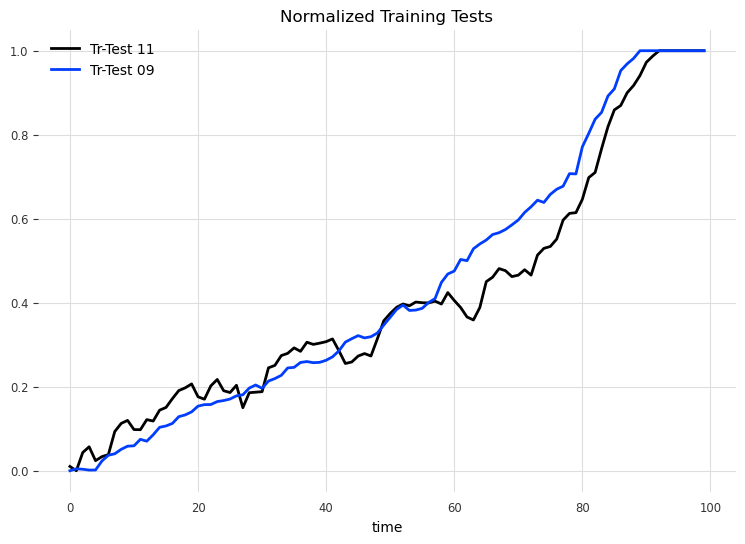

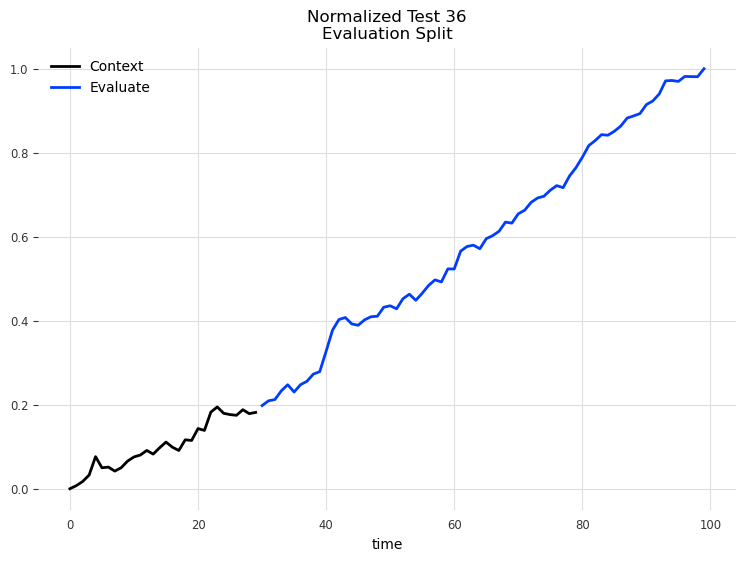

In [10]:
plt.figure(figsize=figsize)
test_A_transformed.plot(label="Tr-{}".format(tests_encoder["A"]))
test_B_transformed.plot(label="Tr-{}".format(tests_encoder["B"]))
plt.title("Normalized Training Tests")

plt.figure(figsize=figsize)
trainC_transformed.plot(label="Context")
valC_transformed.plot(label="Evaluate")
plt.title("Normalized {}\nEvaluation Split".format(tests_encoder["C"]))
plt.show()

# Define hyperparameters for the TFT

In [11]:
# Define hyperparams of the TFT
start_time = time.time()
input_chunk_length = 20
forecast_horizon = 4
num_epochs = 400
#Hyperparams for model D Architecture - see the paper for further details on hyperparameter selection
hidden_sizes = 256
lstms = 4
att_heads = 4

## Without Covariates (Figure 10, T36 30%, 50%, 70%)

In [12]:
training_cutoff = 29
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
print("Evaluation Test Split: {}/{}".format(len(trainC_transformed),len(valC_transformed)))
#fit the model
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_sizes,
    lstm_layers=lstms,
    num_attention_heads=att_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=num_epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    force_reset=True
)

Evaluation Test Split: 30/70


In [13]:
#Fit the model
test_model.fit(series=[test_A_transformed, test_B_transformed],
              future_covariates=[covariates_transformed, covariates_transformed],
               verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=256, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=4, batch_size=16, n_epochs=400, add_encoders=None, random_state=42, force_reset=True)

In [14]:
#Get prediction for 70 Steps ahead
pred_30 = test_model.predict(n=prediction_length,
                             series=trainC_transformed,
                             num_samples=num_samples,
                             future_covariates=covariates_transformed,
                             verbose=False)
#Compute MAPE
MAPE_30 = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
               pred_series=transformer_C.inverse_transform(pred_30))
#Adjust Context/Evaluation Split
training_cutoff = 49
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
#Get prediction for 50 Steps ahead
pred_50 = test_model.predict(n=prediction_length,
                             series=trainC_transformed,
                             num_samples=num_samples,
                             future_covariates=covariates_transformed,
                             verbose=False)
#Compute MAPE
MAPE_50 = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
               pred_series=transformer_C.inverse_transform(pred_50))
#Adjust Context/Evaluation Split
training_cutoff = 69
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
#Get prediction for 30 Steps ahead
pred_70 = test_model.predict(n=prediction_length,
                             series=trainC_transformed,
                             num_samples=num_samples,
                             future_covariates=covariates_transformed,
                             verbose=False)
#Compute MAPE
MAPE_70 = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
               pred_series=transformer_C.inverse_transform(pred_70))

In [16]:
print("Len pred_30: {}, MAPE_30: {:.2f}".format(len(pred_30), MAPE_30))
print("Len pred_50: {}, MAPE_50: {:.2f}".format(len(pred_50), MAPE_50))
print("Len pred_70: {}, MAPE_70: {:.2f}".format(len(pred_70), MAPE_70))

Len pred_30: 70, MAPE_30: 6.60
Len pred_50: 50, MAPE_50: 6.08
Len pred_70: 30, MAPE_70: 4.35


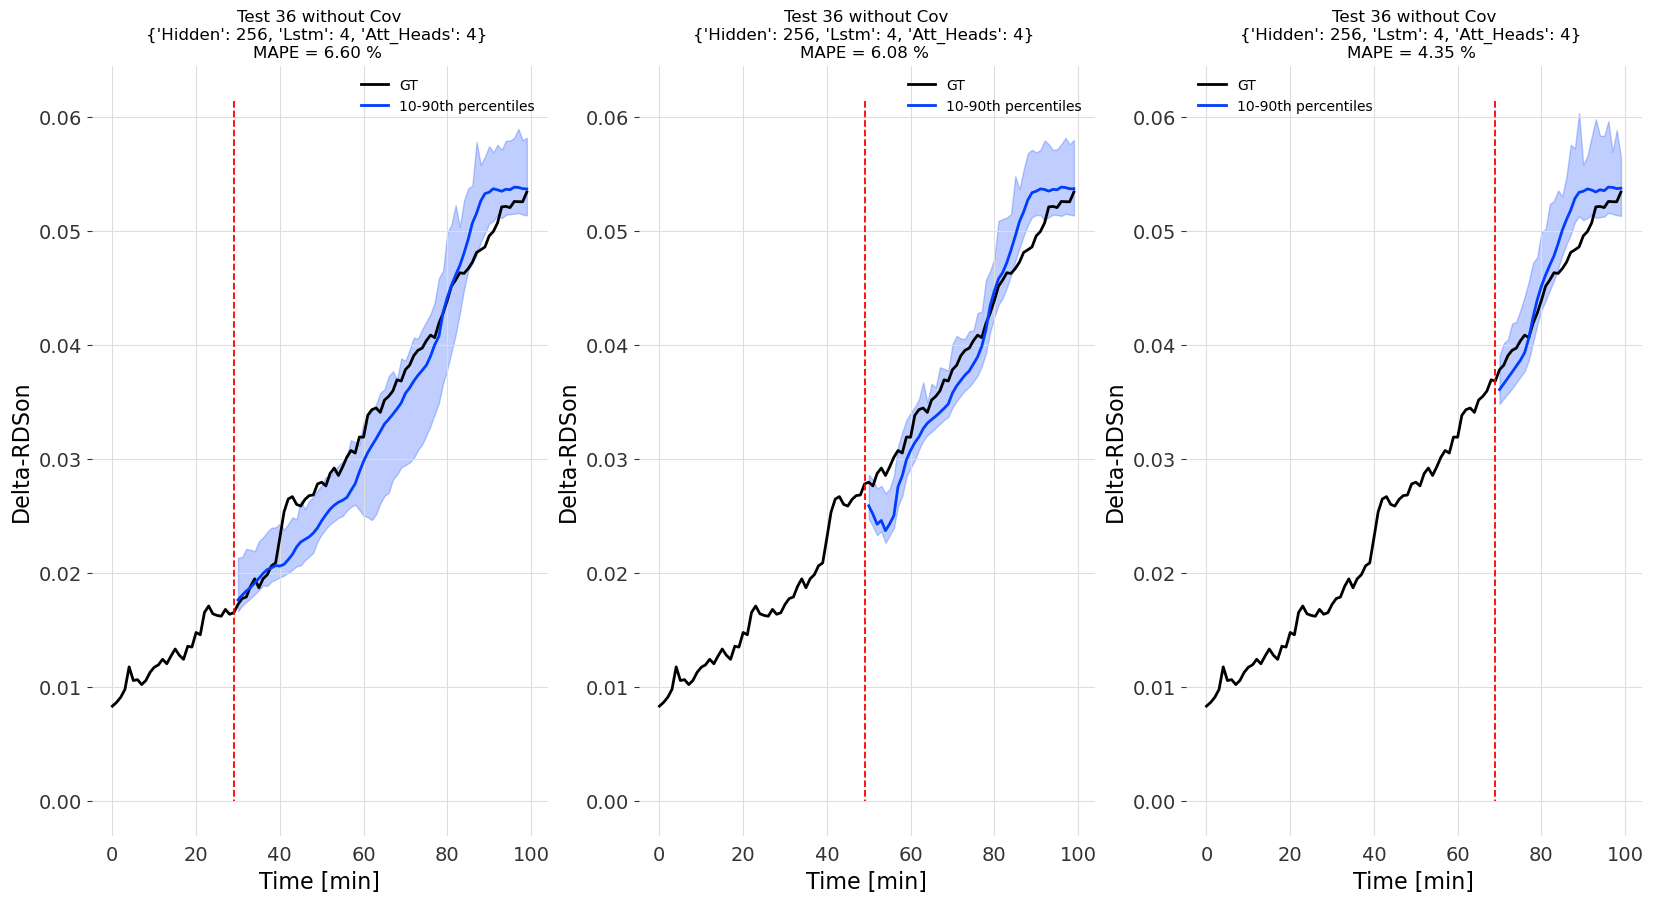

In [15]:
#plotting
params = {"Hidden":hidden_sizes,"Lstm":lstms,"Att_Heads":att_heads}
testName = "{} without Cov\n{}".format(tests_encoder["C"],params)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_30).plot(low_quantile=0.025, high_quantile=0.975,
                                              label=label_q_inner)
training_cutoff = 29
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_30))
plt.legend()
plt.subplot(1,3,2)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_50).plot(low_quantile=0.025, high_quantile=0.975,
                                              label=label_q_inner)
training_cutoff = 49
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_50))
plt.legend()
plt.subplot(1,3,3)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_70).plot(low_quantile=0.025, high_quantile=0.975,
                                              label=label_q_inner)
training_cutoff = 69
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_70))
plt.legend()
plt.show()

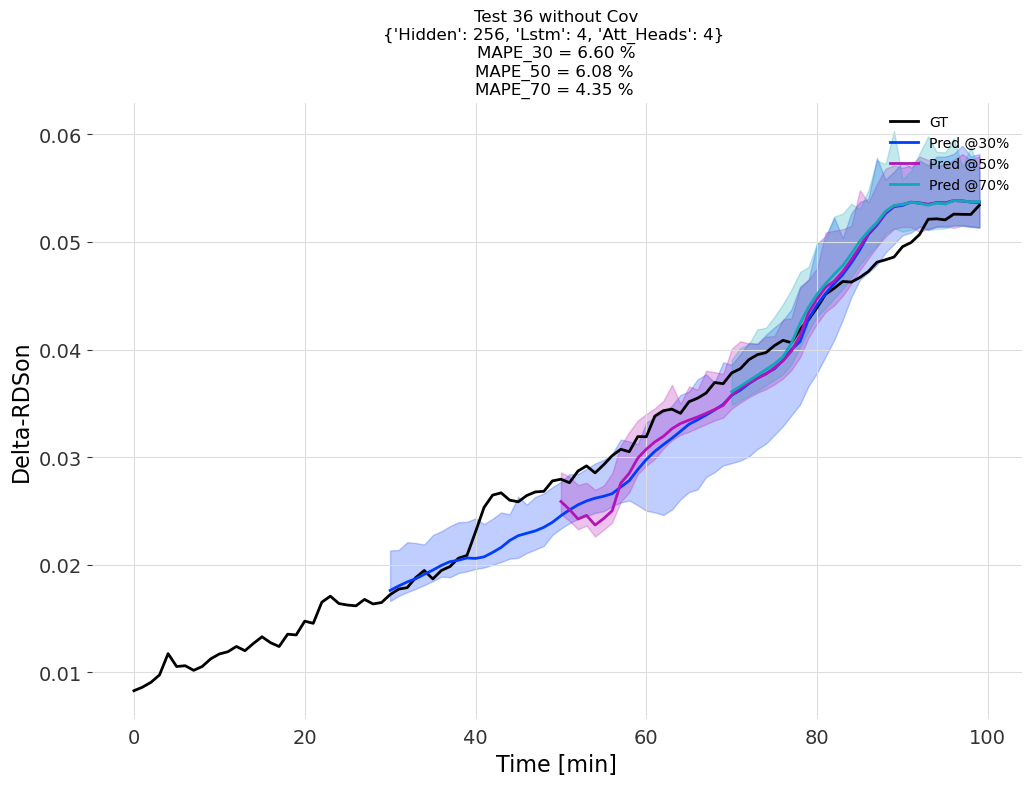

In [23]:
#plotting
params = {"Hidden":hidden_sizes,"Lstm":lstms,"Att_Heads":att_heads}
testName = "{} without Cov\n{}".format(tests_encoder["C"],params)
plt.figure(figsize=(12,8))
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_30).plot(low_quantile=0.025, high_quantile=0.975,
                                              label="Pred @30%")
transformer_C.inverse_transform(pred_50).plot(low_quantile=0.025, high_quantile=0.975,
                                              label="Pred @50%")
transformer_C.inverse_transform(pred_70).plot(low_quantile=0.025, high_quantile=0.975,
                                              label="Pred @70%")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE_30 = {:.2f} %\nMAPE_50 = {:.2f} % \nMAPE_70 = {:.2f} % ".format(testName, MAPE_30, MAPE_50, MAPE_70))
plt.legend()
plt.show()

## With Covariates (Figure 10, T36 30%, 50%, 70%)

In [17]:
#Adjust Context/Evaluation Split
training_cutoff = 29
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
#Define Model
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_sizes,
    lstm_layers=lstms,
    num_attention_heads=att_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=num_epochs,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42,
    force_reset=True
)
#Fit the Model
test_model.fit(series=[test_A_transformed, test_B_transformed],
               future_covariates=[covariate_tC, covariate_tC],
               verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=256, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=4, batch_size=16, n_epochs=400, add_encoders=None, random_state=42, force_reset=True)

In [18]:
#Get prediction for 70 steps ahead
pred_30_wC = test_model.predict(n=prediction_length,
                                series=trainC_transformed,
                                num_samples=num_samples,
                                future_covariates=covariate_tC,
                                verbose=False)
#Compute MAPE
MAPE_30_wC = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
                  pred_series=transformer_C.inverse_transform(pred_30_wC))
#Adjust Context/Evaluation Split
training_cutoff = 49
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
#Get prediction for 50 steps ahead
pred_50_wC = test_model.predict(n=prediction_length,
                                series=trainC_transformed,
                                num_samples=num_samples,
                                future_covariates=covariate_tC,
                                verbose=False)
#Compute MAPE
MAPE_50_wC = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
                  pred_series=transformer_C.inverse_transform(pred_50_wC))
#Adjust Context/Evaluation Split
training_cutoff = 69
prediction_length = 100 - training_cutoff - 1
trainC_transformed, valC_transformed = test_C_transformed.split_after(training_cutoff)
#Get prediction for 30 steps ahead
pred_70_wC = test_model.predict(n=prediction_length,
                                series=trainC_transformed,
                                num_samples=num_samples,
                                future_covariates=covariate_tC,
                                verbose=False)
#Compute MAPE
MAPE_70_wC = mape(actual_series=transformer_C.inverse_transform(valC_transformed),
                  pred_series=transformer_C.inverse_transform(pred_70_wC))
print("Len pred_30: {}, MAPE_30: {:.2f}".format(len(pred_30), MAPE_30_wC))
print("Len pred_50: {}, MAPE_50: {:.2f}".format(len(pred_50), MAPE_50_wC))
print("Len pred_70: {}, MAPE_70: {:.2f}".format(len(pred_70), MAPE_70_wC))

Len pred_30: 70, MAPE_30: 7.87
Len pred_50: 50, MAPE_50: 6.96
Len pred_70: 30, MAPE_70: 4.04


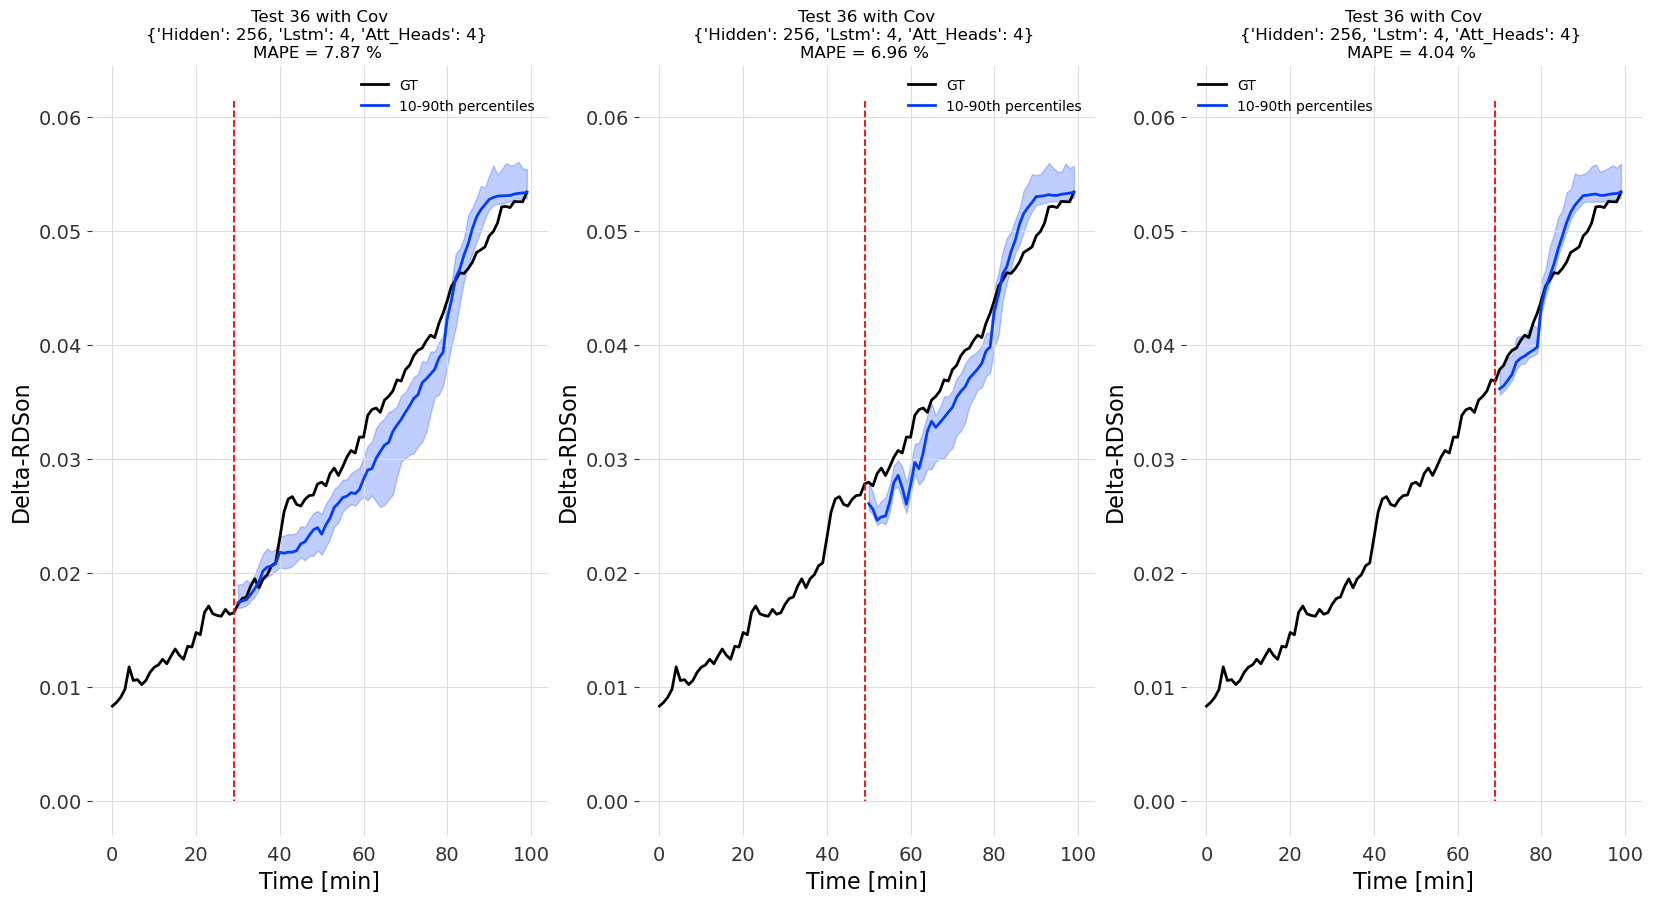

In [19]:
#plotting
params = {"Hidden": hidden_sizes, "Lstm": lstms, "Att_Heads": att_heads}
testName = "{} with Cov\n{}".format(tests_encoder["C"], params)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_30_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label=label_q_inner)
training_cutoff = 29
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_30_wC))
plt.legend()
plt.subplot(1, 3, 2)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series.plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_50_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label=label_q_inner)
training_cutoff = 49
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_50_wC))
plt.legend()
plt.subplot(1, 3, 3)
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series.plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_70_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label=label_q_inner)
training_cutoff = 69
MAX_VAL = MAX_VAL[0]
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} % ".format(testName, MAPE_70_wC))
plt.legend()
plt.show()

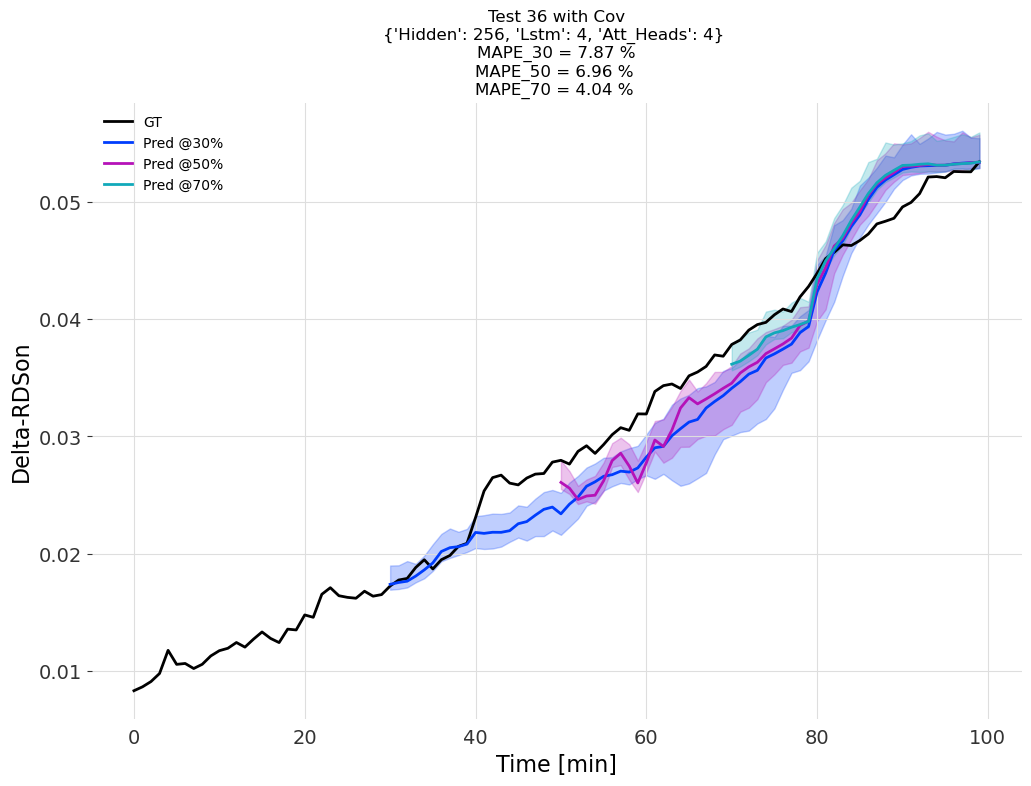

In [20]:
#plotting
params = {"Hidden": hidden_sizes, "Lstm": lstms, "Att_Heads": att_heads}
testName = "{} with Cov\n{}".format(tests_encoder["C"], params)
plt.figure(figsize=(12, 8))
if SELECTOR == 1:
    MAX_VAL = max(test09_series.values())
    test09_series[0:90].plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test11_series.values())
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test36_series.values())
    test36_series.plot(label="GT")
transformer_C.inverse_transform(pred_30_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label="Pred @30%")
transformer_C.inverse_transform(pred_50_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label="Pred @50%")
transformer_C.inverse_transform(pred_70_wC).plot(low_quantile=low_q, high_quantile=high_q,
                                              label="Pred @70%")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title(
    "{} \nMAPE_30 = {:.2f} %\nMAPE_50 = {:.2f} % \nMAPE_70 = {:.2f} % ".format(testName, MAPE_30_wC, MAPE_50_wC, MAPE_70_wC))
plt.legend()
plt.show()

## Summary

In [21]:
print("Evaluation test: {}".format(tests_encoder["C"]))
print("-------------------------------------------------------------------")
print("               @30%     @50%     @70%")
print("without Cov    {:.2f}    {:.2f}    {:.2f}".format(MAPE_30, MAPE_50, MAPE_70))
print("with Cov      {:.2f}    {:.2f}    {:.2f}".format(MAPE_30_wC, MAPE_50_wC, MAPE_70_wC))

Evaluation test: Test 36
-------------------------------------------------------------------
               @30%     @50%     @70%
without Cov    6.60    6.08    4.35
with Cov      7.87    6.96    4.04


In [24]:
end_time = time.time()
elapsed_time = end_time-start_time
print("Elapsed time = {:.0f} minutes".format(elapsed_time / 60))

Elapsed time = 85 minutes


# To complete all the results in Figure 10 change the test numbers.

In [22]:
# END